# Tutorial 1

**This is a direct port of the R `dftools` [tutorial](http://rpubs.com/obreschkow/312101) to Python.**

**Objective of tutorial:** Illuystrate the basic functionality of `pydftools` by reproducing the HI mass function in Fig. 7 of Westmeier et al. 2017 (https://arxiv.org/pdf/1709.00780.pdf).

Load the relevant libraries:

In [5]:
%matplotlib inline

import pydftools as df
from pydftools.plotting import mfplot
import numpy as np
from urllib.request import Request, urlopen # For getting the data online

from IPython.display import display, Math, Latex, Markdown, TextDisplayObject

Download the HI-mass data of Westmeier et al. 2017:

In [6]:
req = Request('http://quantumholism.com/dftools/westmeier2017.txt', headers={'User-Agent': 'Mozilla/5.0'})
data  = urlopen(req)

data = np.genfromtxt(data, skip_header=1)

There are 31 galaxies in this sample, hence the array has 31 rows. This data can be recast into the log-masses $x$, normally used by `pydftools`. We assume the mass uncertainties to be normal in $x$ and determine their amplitude using linear error propagation. We also define the vector of effective volumes:

In [7]:
x = np.log10(data[:,0])
x_err = data[:,1]/data[:,0]/np.log(10)
veff_values = data[:,2]

Now fit these data. We first must create a Data and Selection object:

In [9]:
data = df.dffit.Data(x = x, x_err=x_err)
selection = df.selection.SelectionVeffPoints(veff=veff_values, xval = x, xmin = 5, xmax = 13)

In [10]:
survey = df.DFFit(data = data, selection=selection, grid_dx = 0.01)

/home/steven/Documents/Projects/DFTOOLS/pydftools/pydftools/plotting.py:410: RuntimeWarning: divide by zero encountered in true_divide
  bin['gdf_input'] = np.bincount(x_bins, weights=1 / bin['dx'] / v, minlength=bin['n'])
/home/steven/Documents/Projects/DFTOOLS/pydftools/pydftools/dffit.py:917: RuntimeWarning: invalid value encountered in true_divide
  self.grid.effective_counts = rho_unbiased ** 2 / rho_unbiased_sqr  # this equation gives the effective number of sources per bin
/home/steven/anaconda2/envs/dftools/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2951: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


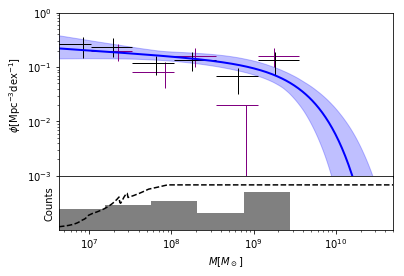

In [11]:
mfplot(survey, xlim=(10**6.63, 5e10), ylim=(1e-3, 1), show_bias_correction=False);

and show the fitted parameters:

In [12]:
display(Markdown(survey.fit_summary(format_for_notebook=True)))

$\frac{dN}{dVdx} = \log(10) \phi_\star \mu^{\alpha+1} \exp(-\mu)$, where $\mu = 10^{x - \log_{10} M_\star}$<br><br>$\log_{10} \phi_\star$ =   -1.315 (+-0.275)<br>$\log_{10} M_\star$ =    9.540 (+-0.307)<br>$\alpha$ =   -1.102 (+-0.147)<br>

The dashed line in the bottom panel shows the effective volume as a function of mass, recovered from the 31 values of ``veff``. By default an effective volume of 0 for masses smaller than the smallest observed mass, and identical to the maximum volume for masses larger than the largest observed mass. If a better model is available from survey-specific considerations, then this information can be exploited to improve the fit. In this example, we replace the assumption of ``veff=0`` for ``x<xmin``, by ``veff=max(0,(x−6.53)∗75)``:

In [13]:
def veff_extrap(x):
    veff_max = np.max(veff_values)
    return np.clip((x-6.53)*75, 0,veff_max)

selection = df.selection.SelectionVeffPoints(veff=veff_values, xval = x, veff_extrap=veff_extrap, xmin = 5, xmax = 13)

Now fit again:

In [14]:
survey = df.DFFit(data = data, selection=selection, grid_dx = 0.01)

and see the best fit solution:

In [15]:
display(Markdown(survey.fit_summary(format_for_notebook=True)))

$\frac{dN}{dVdx} = \log(10) \phi_\star \mu^{\alpha+1} \exp(-\mu)$, where $\mu = 10^{x - \log_{10} M_\star}$<br><br>$\log_{10} \phi_\star$ =   -1.308 (+-0.272)<br>$\log_{10} M_\star$ =    9.535 (+-0.305)<br>$\alpha$ =   -1.097 (+-0.146)<br>

As can be seen the parameters have change very slightly due to the modified effecive volume at the lowest masses. The printed parameters have symmetric Gaussian uncertainties, determined in the Lapace approximation (i.e. by inverting the Hessian matrix of the modified likelihood function). To allow for non-Gaussian parameter posteriors, we now refit the data while bootstrapping it 10^3 times:

In [16]:
survey.resample(n_bootstrap = 1000)

/home/steven/anaconda2/envs/dftools/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Finally, let’s produce the plot with 68% and 95% confidence regions around the best fit. Also change fit color to red, change data color to black, remove posterior data, remove effective volume line, and adjust binning of input data. Then, add HIPASS and ALFALFA lines.

/home/steven/Documents/Projects/DFTOOLS/pydftools/pydftools/dffit.py:917: RuntimeWarning: invalid value encountered in true_divide
  self.grid.effective_counts = rho_unbiased ** 2 / rho_unbiased_sqr  # this equation gives the effective number of sources per bin


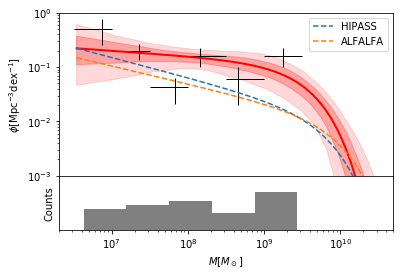

In [17]:
fig, ax = mfplot(survey,xlim=(2e6,5e10),ylim=(1e-3,1),uncertainty_type=3,
                 col_fit='red',col_data='black',show_posterior_data=False,
                 ls_veff='none', nbins=6,bin_xmin=6.5,bin_xmax=9.5,
                 show_bias_correction=False,
                 xpower10=True)
x = survey.grid.x[0]

ax[0].plot(10**x, survey.model.gdf(x,[np.log10(6.0e-3),9.80,-1.37]), ls='--',lw=1.5, color='C0', label="HIPASS") 
ax[0].plot(10**x, survey.model.gdf(x,[np.log10(4.8e-3),9.96,-1.33]), ls='--',lw=1.5, color='C1', label="ALFALFA")
ax[0].legend()

and write the bes-fitting parameters:

In [18]:
display(Markdown(survey.fit_summary(format_for_notebook=True)))

$\frac{dN}{dVdx} = \log(10) \phi_\star \mu^{\alpha+1} \exp(-\mu)$, where $\mu = 10^{x - \log_{10} M_\star}$<br><br>$\log_{10} \phi_\star$ =   -1.308 (+0.240 -0.279)<br>$\log_{10} M_\star$ =    9.535 (+0.171 -0.174)<br>$\alpha$ =   -1.097 (+0.174 -0.140)<br>

Note that there are marginal differences to the uncertainty ranges quoted in the publication, due to a difference in the bootstrapping technique used in the publication (parametric bootstrapping) and the current version of dftools (non-parametric bootstrapping).